<font color="black"><font size="7"><br>
     Project 6 - NLP
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import math
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from collections import defaultdict

# Loading data

In [ ]:
#Create the columns for dataframe
with open("D:/Data OC/P6/yelp_academic_dataset_review.json",encoding="utf8") as f:
     for i, line in enumerate(f):
        first_line = json.loads(line)
        if i>=0:
            break
data = pd.DataFrame(columns=first_line.keys())


#parse data and load in dataframe
with open("D:/Data OC/P6/yelp_academic_dataset_review.json",encoding="utf8") as f:
     for i, line in enumerate(f):
            data.loc[i] = json.loads(line).values()
            if i>=150000: # limit number of reviews
                break

#Keep index, stars and text
df_text = data[['stars','text']].copy()
df_text.rename(columns={'stars':'stars_rating'},inplace=True)


In [ ]:
df_text.to_pickle('data/df_text')

In [ ]:
df_text = pd.read_pickle('data/df_text')

# Tokenizer

In [2]:
def tokenizer(data):
    '''tokenizes input dataframe considering words of 2 and more characters
    
       Parameters
       ----------
       data : pandas DataFrame with \'text\' columns to tokenize
       
       Returns
       --------
       data : pandas DataFrame with \'tokens\' column added as a list of tokens
              and \'tokenized_text\' column with the joined tokens as str separated by space'''
        
    tokenizer = nltk.RegexpTokenizer(r'\w{2,}')
    data['text']=data['text'].str.lower()
    data['tokens']=data.apply(lambda row: tokenizer.tokenize(row['text']),axis=1)
    data['tokenized_text']=data.apply(lambda row: ' '.join(row['tokens']),axis=1)
    return data

# Stemming

In [3]:
def stemmer(data):
    ''' Stems the column named \'token\' and create a \'stem\' columns along with a joined version \'stemmed_text\' '''

    pstemmer = PorterStemmer()

    def stem_sentence(tokenized_sentence):
        stems = [pstemmer.stem(i) for i in tokenized_sentence]
        return stems

    data['stems'] = data.apply(
        lambda row: stem_sentence(row['tokens']), axis=1)
    data['stemmed_text'] = data.apply(
        lambda row: ' '.join(row['stems']), axis=1)
    return data

# Adding n-grams

We want to compute n_grams before removing stopword to keep negative and expression

In [4]:
def add_bigrams(data):
    ''' Add bigrams in a separate columns of data \'bigrams\' '''
       
    bigrams_corpus = []
    
    for text_id in data.index:
        
        stems=data.loc[text_id,'stems']
        
        bigrams=[]
        
        for i in range(len(stems)-2):
            
            bigrams.append(' '.join(stems[i:i+2]))
            
        bigrams_corpus.append(bigrams) 
   
       
    data['bigrams'] = bigrams_corpus
    
    return data

# removing stop words

In [5]:
def remove_stopwords(data, stopwords):
    '''Remove stopwords from stems and bigrams, stopwords must be stemmed before feeding it to the function'''

    # remove stopwords from stems and create a new column
    data['clean_stems'] = [[stem for stem in stems if (
        not(stem in stopwords))] for stems in data['stems']]
    data['clean_stemmed_text'] = data.apply(
        lambda row: ' '.join(row['clean_stems']), axis=1)

    # remove bigrams that contains two stopwords
    data['clean_bigrams'] = [[bigram for bigram in bigrams if (not(all(
        item in stopwords for item in bigram.split())))] for bigrams in data['bigrams']]

    return data

# removing words appearing only once

In [6]:
def remove_single_appearance(data):
    
    '''Removes single appearance of stems and bigrams'''
    
    frequency = defaultdict(int)
    for stems in data['clean_stems']:
        for stem in stems:
            frequency[stem] += 1
            
    data['filtered_stems']= [
        [stem for stem in stems if frequency[stem] > 1] 
        for stems in data['clean_stems']]
    
    frequency = defaultdict(int)
    for bigrams in data['clean_bigrams']:
        for bigram in bigrams:
            frequency[bigram] += 1
            
    data['filtered_bigram']= [[bigram for bigram in bigrams if frequency[bigram] > 1] for bigrams in data['bigrams']]
    
    return data

#  removing mot common stems and bigrams

In [7]:
def frequency_dataframe(stems_df,bigrams_df):
    '''compute and returns a dataframe with frequency of each items in stems_df and bigrams_df'''
    
    frequency = defaultdict(int)
    for stems in stems_df:
        for stem in stems:
            frequency[stem] += 1
            
    for bigrams in bigrams_df:
        for bigram in bigrams:
            frequency[bigram] += 1
    
    
    freq_df=pd.DataFrame(index=frequency.keys(),columns=['freq'])
    freq_df['freq']=[frequency[key] for key in freq_df.index]
    freq_df['freq']=freq_df['freq'] / freq_df.shape[0]
    
    return freq_df

In [8]:
def remove_most_common(data,threshold=0.01):
    '''removes the most communs stems and bigrams according to threshold (percentage)'''
    
    
    frequencies_df = frequency_dataframe(data['filtered_stems'],data['filtered_bigram'])
    items_to_remove = frequencies_df[frequencies_df['freq'] > threshold].index.tolist()
    
    data['significant_stems'] = [[stem for stem in stems if (not(stem in items_to_remove))] for stems in data['filtered_stems']]
    data['significant_bigrams'] = [[bigram for bigram in bigrams if (not(bigram in items_to_remove))] for bigrams in data['filtered_bigram']]
    
    return data

# creating a preprocessing pipeline

In [9]:
def preprocessing_text(data, stopwords, threshold):

    preprocessed_text = remove_most_common(
        remove_single_appearance(
            remove_stopwords(
                add_bigrams(
                    stemmer(
                        tokenizer(data)
                    )
                ),
                stopwords
            )
        ),
        threshold
    )
    
    data['preprocessed_items']=data['significant_stems']+data['significant_bigrams']
    return data

In [10]:
stopwords = nltk.corpus.stopwords.words('english')

In [11]:
pstemmer = PorterStemmer()

In [12]:
stopwords_stem = [pstemmer.stem(words) for words in stopwords]

In [ ]:
df_text = preprocessing_text(df_text, stopwords_stem, threshold=0.01)

In [ ]:
df_text.to_pickle('data/df_text_preprocessed')

In [13]:
df_text = pd.read_pickle('data/df_text_preprocessed')

# Exploratory analysis

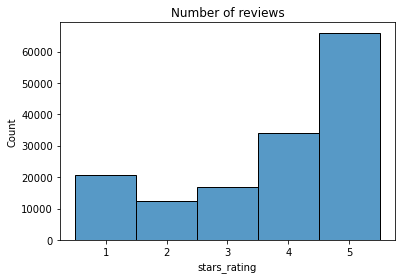

In [14]:
sns.histplot(df_text['stars_rating'],discrete=True)
plt.title('Number of reviews')
plt.show()

In [15]:
df_text['nb_words'] = df_text['tokens'].str.len()

In [16]:
df_text['nb_unique_words']=df_text.apply(lambda row: len(set(row['tokens'])),axis=1)

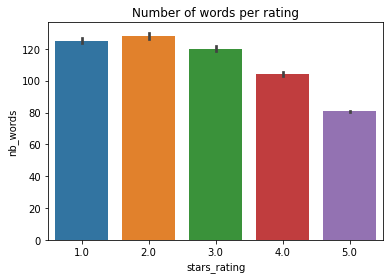

In [17]:
sns.barplot(x=df_text['stars_rating'],y=df_text['nb_words'])
plt.title('Number of words per rating')
plt.show()

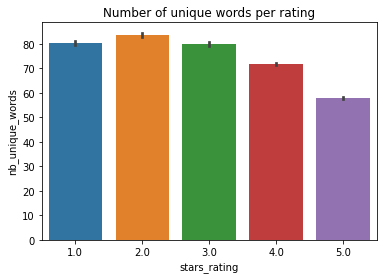

In [18]:
sns.barplot(x=df_text['stars_rating'],y=df_text['nb_unique_words'])
plt.title('Number of unique words per rating')
plt.show()

In [19]:
df_text['nb_significant_stems'] = df_text['significant_stems'].str.len()

In [20]:
df_text['nb_unique_significant_stems']=df_text.apply(lambda row: len(set(row['significant_stems'])),axis=1)

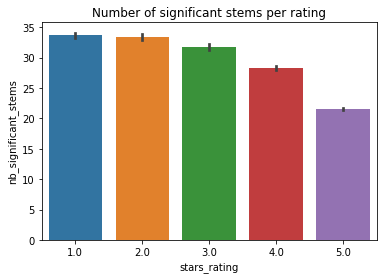

In [21]:
sns.barplot(x=df_text['stars_rating'],y=df_text['nb_significant_stems'])
plt.title('Number of significant stems per rating')
plt.show()

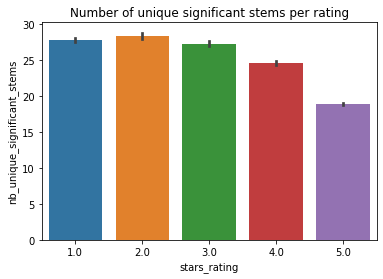

In [22]:
sns.barplot(x=df_text['stars_rating'],y=df_text['nb_unique_significant_stems'])
plt.title('Number of unique significant stems per rating')
plt.show()

# Bag of words

working on 1 and 2 stars reviews

In [2]:
df_text = pd.read_pickle('data/df_text')

In [18]:
df_text_neg = df_text[df_text['stars_rating']<=2].copy()

In [19]:
df_text_neg = preprocessing_text(df_text_neg, stopwords_stem, threshold=0.01)

In [21]:
df_text_neg.to_pickle('data/df_text_negative_preprocessed')

In [13]:
df_text_neg=pd.read_pickle('data/df_text_negative_preprocessed')

In [14]:
from gensim import corpora
from gensim import models

In [15]:
dictionary = corpora.Dictionary(df_text_neg['preprocessed_items'])

In [16]:
bow_corpus = [dictionary.doc2bow(text) for text in df_text_neg['preprocessed_items']]

# Word embedding

## LDA

In [17]:
lda_model = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=15, minimum_probability=0)

## LDAviz

In [20]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning) 

import pyLDAvis

C:\Users\Soyann\Code\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
from pyLDAvis import gensim

In [22]:
vis_data = gensim.prepare(lda_model,bow_corpus,dictionary=dictionary)

In [23]:
pyLDAvis.display(vis_data)

In [33]:
pyLDAvis.save_html(vis_data, 'lda.html')

## Wordcloud

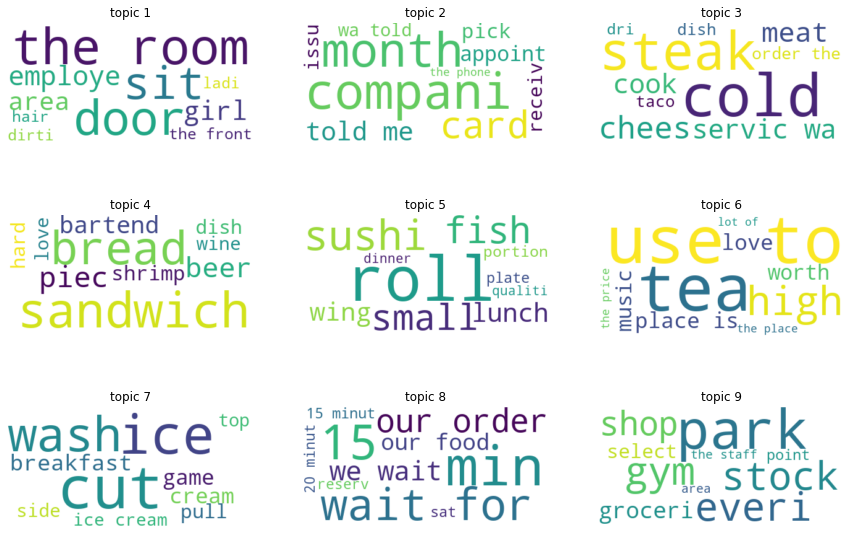

In [24]:
topic_order = vis_data.topic_order[0:9]
import wordcloud
cloud = wordcloud.WordCloud(background_color='white')

fig, axs = plt.subplots(3, 3, figsize=(15, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()

i=0
for topic_id in topic_order:
    plt.subplot(axs[i]) 
    cloud.fit_words(dict(lda_model.show_topic(topic_id-1)))
    axs[i].imshow(cloud, interpolation='bilinear',)
    axs[i].axis("off")
    plt.title(f'topic {i+1}')
    i+=1

# Thoughts about classification

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer

In [39]:
vectorizer_idf = TfidfVectorizer(token_pattern=r'\w+',
                             stop_words=stopwords_stem,
                             ngram_range=(1,2),
                             smooth_idf=False,
                             use_idf=True)

## Creating 5 different corpus

In [40]:
corpus=[]
for i in [1,2,3,4,5]:
    corpus.append(' '.join(df_text[df_text['stars_rating']==i]['stemmed_text'].values))

In [41]:
X_idf = vectorizer_idf.fit_transform(corpus)
stems_idf =vectorizer_idf.get_feature_names()

C:\Users\Soyann\Code\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['r', 'v'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


### Most commun stems per corpus based on tf-idf

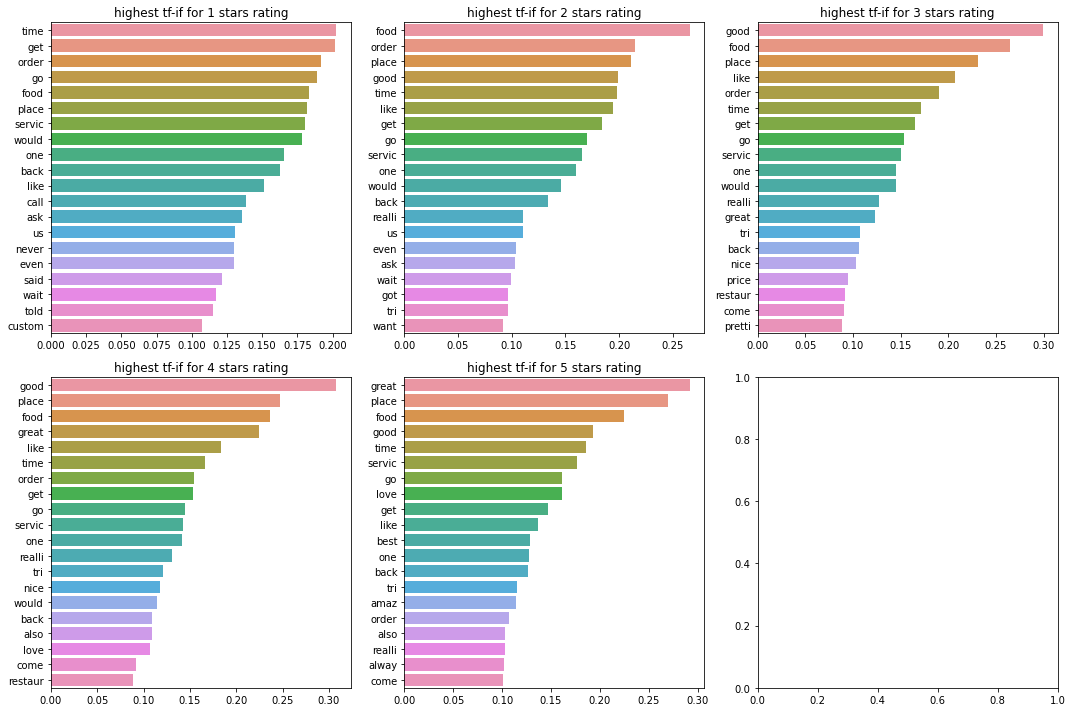

In [42]:
values_idf = [X_idf[i].toarray()[0] for i in range(X_idf.shape[0])]

stems_values_idf=[]
for i in range(X_idf.shape[0]):
    stems_values_idf.append(dict(zip(stems_idf,values_idf[i])))


max_index_idf = [np.argsort(X_idf[i].toarray()[0]) for i in range(X_idf.shape[0])]

most_commun_stems_idf=[]
for i in range(X_idf.shape[0]):
    most_commun_stems_idf.append([stems_idf[j] for j in max_index_idf[i][::-1][0:50]])
    
    
    
fig, axs = plt.subplots(2, 3, figsize=(15, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
   
for i in range(X_idf.shape[0]):        
    plt.subplot(axs[i])   
    sns.barplot(y = most_commun_stems_idf[i][0:20],
            x =[stems_values_idf[i][j] for j in most_commun_stems_idf[i][0:20]],
            orient='h')
    plt.title(f'highest tf-if for {i+1} stars rating')


plt.tight_layout()